# Import

In [1]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
MildDemented_dir = r'data\AugmentedAlzheimerDataset\MildDemented'
ModerateDemented_dir = r'data\AugmentedAlzheimerDataset\ModerateDemented'
NonDemented_dir = r'data\AugmentedAlzheimerDataset\NonDemented'
VeryMildDemented_dir = r'data\AugmentedAlzheimerDataset\VeryMildDemented'

filepaths = []
labels = []
dict_list = [MildDemented_dir, ModerateDemented_dir, NonDemented_dir, VeryMildDemented_dir]
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

for i, j in enumerate(dict_list):
    flist = os.listdir(j)
    for f in flist:
        fpath = os.path.join(j, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Alzheimer_data = pd.concat([Fseries, Lseries], axis=1)
df = pd.DataFrame(Alzheimer_data)
print(df.head())
print(df["labels"].value_counts())

                                           filepaths         labels
0  data\AugmentedAlzheimerDataset\MildDemented\00...  Mild Demented
1  data\AugmentedAlzheimerDataset\MildDemented\00...  Mild Demented
2  data\AugmentedAlzheimerDataset\MildDemented\00...  Mild Demented
3  data\AugmentedAlzheimerDataset\MildDemented\00...  Mild Demented
4  data\AugmentedAlzheimerDataset\MildDemented\00...  Mild Demented
labels
Non Demented         9600
Mild Demented        8960
Very MildDemented    8960
Moderate Demented    6464
Name: count, dtype: int64


In [3]:
df.shape

(33984, 2)

# Splitting

In [4]:
train_img, test_img = train_test_split(df, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_img,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 27187 validated image filenames belonging to 4 classes.
Found 6797 validated image filenames belonging to 4 classes.
Found 6797 validated image filenames belonging to 4 classes.


In [6]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

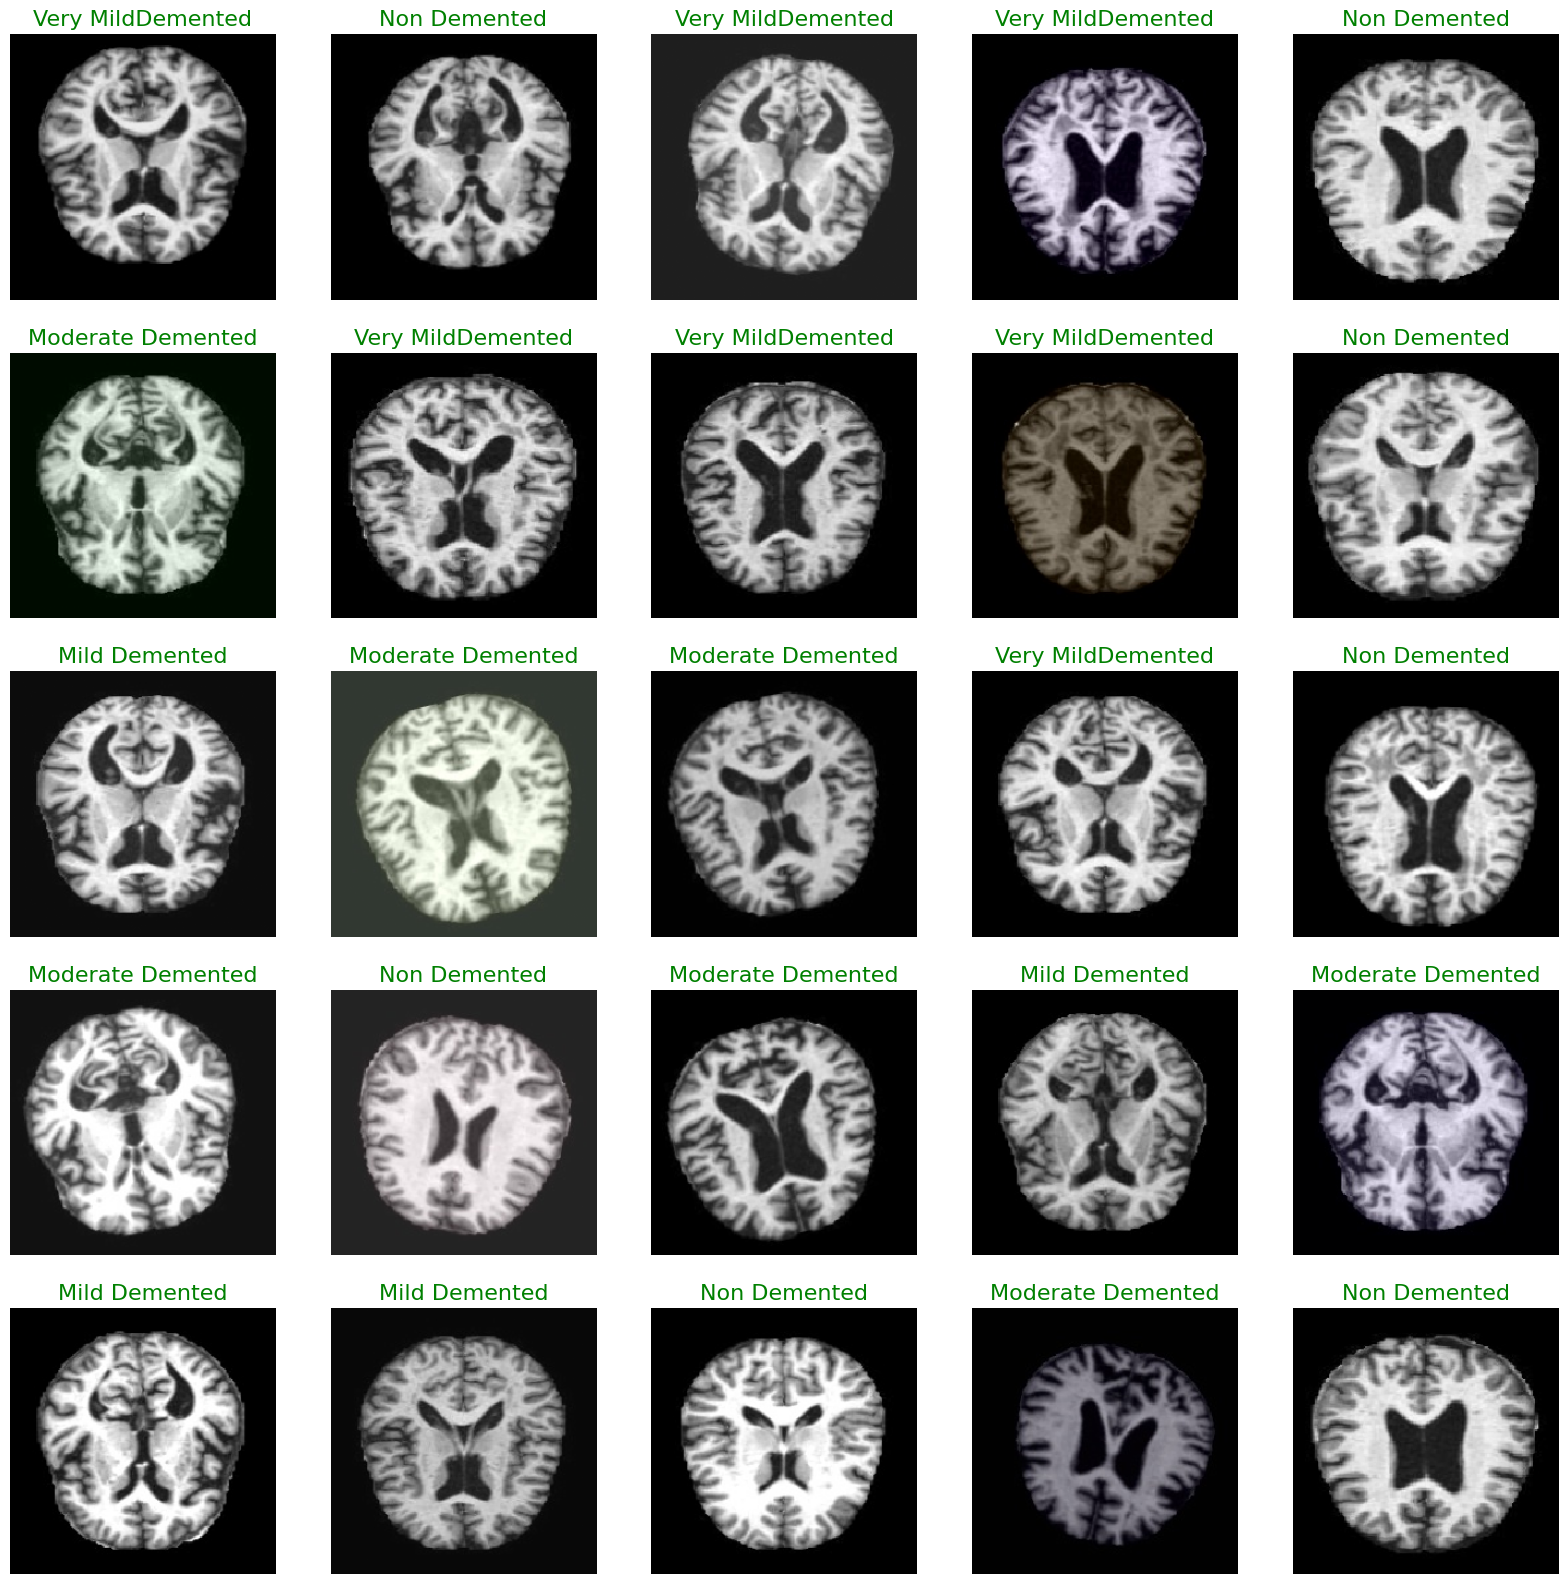

In [7]:
show_knee_images(train)

# Model

In [8]:
model = Sequential([
    Conv2D(16, (2, 2), activation='relu', input_shape=(244, 244, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 243, 243, 16)   │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 121, 121, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 120, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 59, 59, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 53824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,722,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,733,076 (6.61 MB)

 Trainable params: 1,733,076 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

In [10]:
history = model.fit(train, epochs=20, validation_data=val) 

Epoch 1/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 383s 447ms/step - accuracy: 0.3314 - loss: 1.3394 - val_accuracy: 0.4041 - val_loss: 1.2251
Epoch 2/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 183s 215ms/step - accuracy: 0.4676 - loss: 1.1903 - val_accuracy: 0.5398 - val_loss: 1.0606
Epoch 3/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 182s 214ms/step - accuracy: 0.5281 - loss: 1.0701 - val_accuracy: 0.5558 - val_loss: 0.9836
Epoch 4/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 184s 216ms/step - accuracy: 0.5537 - loss: 0.9988 - val_accuracy: 0.5854 - val_loss: 0.9170
Epoch 5/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 183s 215ms/step - accuracy: 0.5720 - loss: 0.9493 - val_accuracy: 0.5898 - val_loss: 0.8864
Epoch 6/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 184s 216ms/step - accuracy: 0.5928 - loss: 0.9081 - val_accuracy: 0.6360 - val_loss: 0.8408
Epoch 7/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 184s 216ms/step - accuracy: 0.5978 - loss: 0.8901 - val_accuracy: 0.6184 - val_loss: 0.8457
Epoch 8/20
850/850 ━━━━━━━━━━━━━━━━━━━━ 183s 215ms/step - accuracy: 0.6124 -

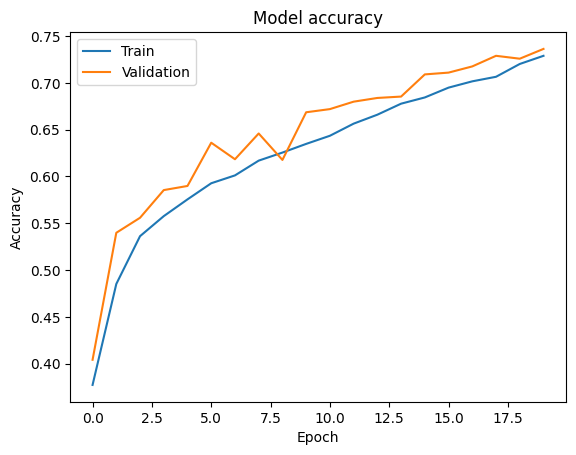

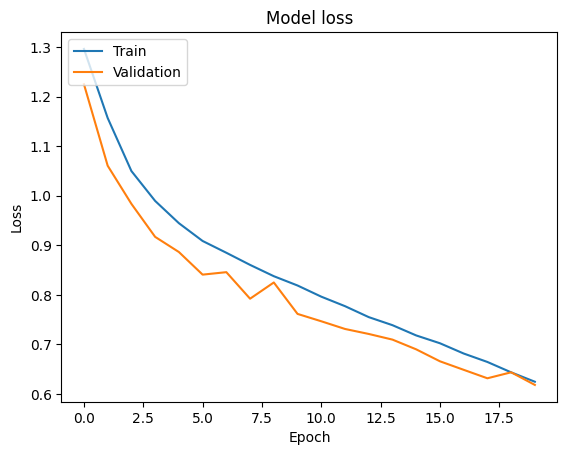

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

loss, accuracy = model.evaluate(test)
print(f'Test Accuracy: {accuracy}')
print(f'Test Loss: {loss}')

In [14]:
model.save('model.keras')

# Demonstration

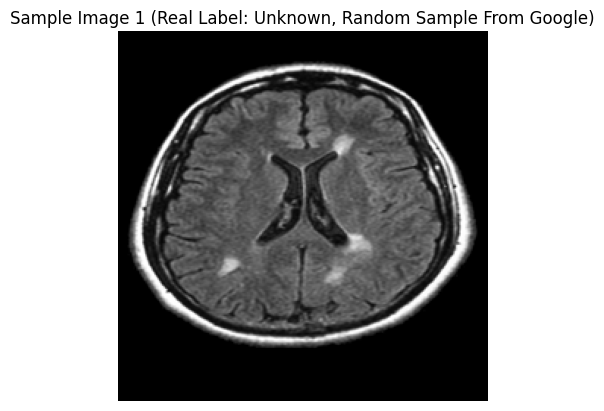

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted Class: Non Demented
Prediction Confidence: [[4.0676082e-03 9.7484940e-07 9.5912194e-01 3.6809471e-02]]


In [8]:
from tensorflow.keras.models import load_model
from PIL import Image

model_path = 'model.keras'
model = load_model(model_path)

# Load and preprocess the sample image
demo_path = 'data/CC7C8857-F56B-4524-8E66-A5DD0D03B16F-540x800.jpeg'
img = Image.open(demo_path).resize((244, 244))
img_array = np.array(img)
img_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

plt.imshow(img)
plt.axis('off')
plt.title('Sample Image 1 (Real Label: Unknown, Random Sample From Google)')
plt.show()

# Expand dimensions to match the input shape of the model
img_preprocessed = np.expand_dims(img_preprocessed, axis=0)

prediction = model.predict(img_preprocessed)

class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']
predicted_class = class_labels[np.argmax(prediction)]

print(f'Predicted Class: {predicted_class}')
print(f'Prediction Confidence: {prediction}')

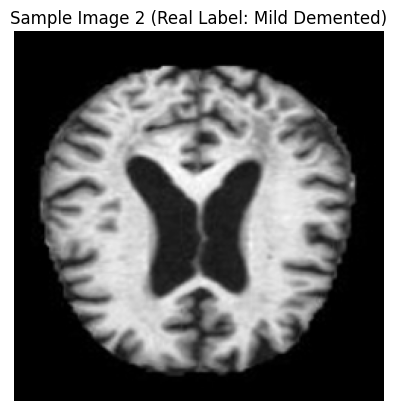

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Class: Mild Demented
Prediction Confidence: [[6.7312038e-01 6.5706461e-04 1.0626072e-01 2.1996184e-01]]


In [9]:
demo_path = 'data/AugmentedAlzheimerDataset/MildDemented/0a0a0acd-8bd8-4b79-b724-cc5711e83bc7.jpg'
img = Image.open(demo_path).resize((244, 244))
img_array = np.array(img)
img_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

plt.imshow(img)
plt.axis('off')
plt.title('Sample Image 2 (Real Label: Mild Demented)')
plt.show()

# Expand dimensions to match the input shape of the model
img_preprocessed = np.expand_dims(img_preprocessed, axis=0)

prediction = model.predict(img_preprocessed)

class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']
predicted_class = class_labels[np.argmax(prediction)]

print(f'Predicted Class: {predicted_class}')
print(f'Prediction Confidence: {prediction}')

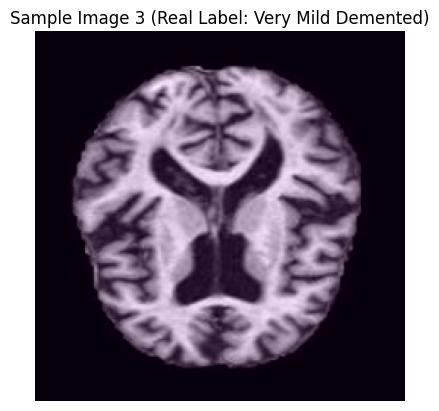

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class: Very Mild Demented
Prediction Confidence: [[8.3745457e-02 4.7068897e-04 8.9269809e-02 8.2651407e-01]]


In [10]:
demo_path = 'data/AugmentedAlzheimerDataset/VeryMildDemented/0a93e274-2cae-4a0a-b535-e1f18c3f9e27.jpg'
img = Image.open(demo_path).resize((244, 244))
img_array = np.array(img)
img_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

plt.imshow(img)
plt.axis('off')
plt.title('Sample Image 3 (Real Label: Very Mild Demented)')
plt.show()

# Expand dimensions to match the input shape of the model
img_preprocessed = np.expand_dims(img_preprocessed, axis=0)

prediction = model.predict(img_preprocessed)

class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']
predicted_class = class_labels[np.argmax(prediction)]

print(f'Predicted Class: {predicted_class}')
print(f'Prediction Confidence: {prediction}')